In [1317]:
from scipy.optimize import fsolve, brentq
from scipy.constants import N_A
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [1318]:
"""
def lig_comp_A1(x1, ftot, x1tot, x2tot, Q1, Q2):

    x2 = ftot - x1*(1 + (Q1/(x1tot - x1)))

    return (ftot - x1 - x2)*(x2tot - x2) - Q2*x2

def lig_comp_A2(x1, ftot, Q1, x1tot):

    return ftot - x1*(1 + (Q1/(x1tot - x1)))
"""

def lig_comp_A2(x2, ftot, x1tot, x2tot, Q1, Q2):

    x1 = (ftot*x2tot - x2*(ftot + x2tot + Q2))/(x2 - x2tot)

    return (ftot - x1 - x2)*(x1tot - x1) - Q1*x1

def lig_comp_A1(x2, ftot, Q2, x2tot):

    return (ftot*x2tot - x2*(ftot + x2tot + Q2))/(x2 - x2tot)

def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

In [1319]:
def lig_comp(t, z, ftot, x1tot, x2tot, k1, k2, koff):

    dx1 = k1*(ftot-z[0]-z[1])*(x1tot-z[0]) - koff*z[0]
    dx2 = k2*(ftot-z[0]-z[1])*(x2tot-z[1]) - koff*z[1]

    dz = [dx1, dx2]

    return dz

def nondim_lig_comp(t, z, alpha1, alpha2, beta1, beta2):

    dx1 = alpha1*(1-z[0]-z[1])*(beta1-z[0]) - z[0]
    dx2 = alpha2*(1-z[0]-z[1])*(beta2-z[1]) - z[1]

    dz = [dx1, dx2]

    return dz

def nondim_lig_poly(z, alpha1, alpha2, beta1, beta2):

    a = -alpha1*(alpha1+alpha2)
    b = alpha2*(alpha1*(beta1 - beta2 +1) + 1) -(alpha1**2)*(2*beta1-1) -alpha1
    c = alpha1*beta1*(alpha2*(beta2-1) + 1 + alpha1*(2-beta1))
    d = -((alpha1*beta1)**2)

    return (z**3) + (b/a)*(z**2) + (c/a)*z + d/a

def nondim_x2(x1, alpha1, beta1):

    return (alpha1*(1 - x1)*(beta1-x1) - x1)/(alpha1*(beta1-x1))

def nondim_stst(x1, alpha1, alpha2, beta1, beta2):

    x2 = (alpha1*(1 - x1)*(beta1-x1) - x1)/(alpha1*(beta1-x1))

    return alpha2*(1-x2 - x1)*(beta2 - x2) -x2

In [1320]:
#parameters

Target_cell_number = 2e5
well_size = 150e-6
E_T_ratio = 1
sigma = well_size*N_A/Target_cell_number
kon = 1e5
koff = 1e-4
rtot = 1e5
synapse_width = 10e-6
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
synapse_area = synapse_width**2
ftot1 = 2.2e2
ftot = ftot1*NK_cell_IS_proportion
D_t = 1e-14
D_f = 7.4e-14
qoff = 4.7e-3
k4 = 2*(D_t +D_f)/(synapse_area)   
k5 = 2*(D_f)/(synapse_area)/1

k2 = 4*D_t/tumour_cell_surface_area
k1 = kon/sigma

Q1 = qoff/k4
Q2 = qoff/k5
A0s = np.geomspace(1e-12, 1e-5, 50)

t =np.geomspace(1e-6, 100, 100)
tspan = [1e-6, 100]
z0 = [0,0]

In [1321]:
print(Q1)

2.7976190476190483


In [1322]:
A1_sol = np.zeros_like(A0s)
A2_sol = np.zeros_like(A0s)
x1_sol = np.zeros_like(A0s)
x2_sol = np.zeros_like(A0s)
x1_sol_1 = np.zeros_like(A0s)
x2_sol_1 = np.zeros_like(A0s)

for i, Ainit in enumerate(A0s):
    Atot = Ainit*sigma
    A1_sol[i] = brentq(A1_steady_state, 0, rtot, args=(Atot, k1, koff, k2, rtot))
    A2_sol[i] = A2_steady_state(A1_sol[i], k2, koff, rtot)

    x1tot = A1_sol[i]*tumour_cell_IS_proportion
    x2tot = A2_sol[i]*tumour_cell_IS_proportion

    alpha1 = ftot/Q1
    alpha2 = ftot/Q2
    beta1 = x1tot/ftot
    beta2 = x2tot/ftot
    print(nondim_stst(0, alpha1, alpha2, beta1, beta2), nondim_stst(beta2, alpha1, alpha2, beta1, beta2))
    x1_sol[i] = brentq(nondim_stst, 0, beta1, args=(alpha1, alpha2, beta1, beta2))
    x2_sol[i] = nondim_x2(x1_sol[i], alpha1, beta1)


    z = solve_ivp(lig_comp, tspan, z0, method='Radau', t_eval=t, args = (ftot, x1tot, x2tot, k4, k5, qoff))
    x1 = z.y[0]
    x2 = z.y[1]
    x1_sol_1[i] = x1[-1]
    x2_sol_1[i] = x2[-1]

x1_sol = x1_sol*ftot
x2_sol = x2_sol*ftot


-1.0 -0.3791634598229713
-1.0 -0.479708591001931
-1.0 -0.6194154344863714
-1.0 -0.813537140490641
-1.0 -1.0832677285255332
-1.0 -1.4580558493215823
-1.0 -1.9788195261478787
-1.0 -2.7024124858485177
-1.0 -3.7078286884312432
-1.0 -5.104819349336626
-1.0 -7.04585231313448
-1.0 -9.74267233526722
-1.0 -13.488992511450665
-1.0 -18.688912632735075
-1.0 -25.73541333037852
-1.0 -28.29351320743463
-1.0 -28.57349931999171
-1.0 -28.72963572682933
-1.0 -28.85503928428681
-1.0 -28.972348236969907
-1.0 -29.091519908225635
-1.0 -29.218809797051733
-1.0 -29.35927273247571
-1.0 -29.517736000026076
-1.0 -29.69930150439248
-1.0 -29.90968953496916
-1.0 -30.155542817515176
-1.0 -30.444750201726066
-1.0 -30.786832091711183
-1.0 -31.19342990964153
-1.0 -31.678953184559973
-1.0 -32.26146087899536
-1.0 -32.96389360119016
-1.0 -33.815841836873204
-1.0 -34.8561547042853
-1.0 -36.13690863491804
-1.0 -37.72965823990721
-1.0 -39.735684096158465
-1.0 -42.30360253790103
-1.0 -45.661382462175325
-1.0 -50.1787334828439


/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_44551/791131368.py:34: RuntimeWarning: divide by zero encountered in double_scalars
  x2 = (alpha1*(1 - x1)*(beta1-x1) - x1)/(alpha1*(beta1-x1))


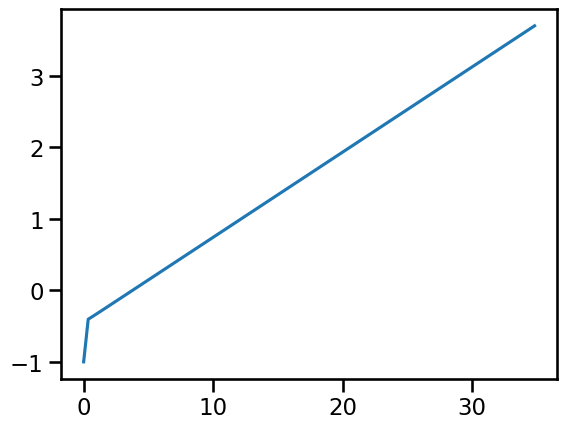

In [1323]:
x=np.linspace(0, beta1, 100)
beta1 = 0.002425272987617065
beta2 = 0.3715653095355283
plt.plot(x, nondim_stst(x, alpha1, alpha2, beta1, beta2))

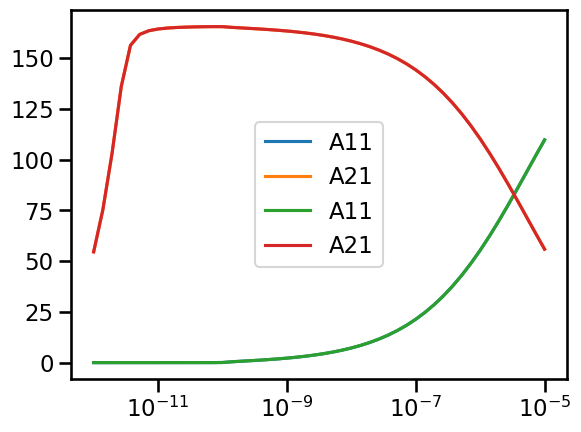

In [1324]:
#plt.semilogx(A0s, A1_sol*tumour_cell_IS_proportion)
#plt.semilogx(A0s, A2_sol*tumour_cell_IS_proportion)
plt.semilogx(A0s, x1_sol, label='A11')
plt.semilogx(A0s, x2_sol, label='A21')
plt.semilogx(A0s, x1_sol_1, label='A11')
plt.semilogx(A0s, x2_sol_1, label='A21')
plt.legend(loc='best')

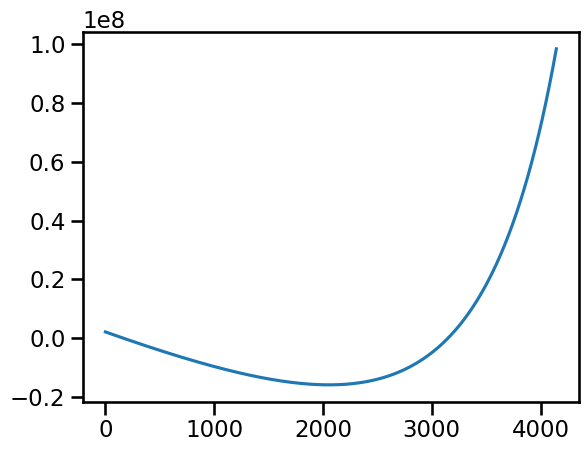

In [1325]:
x=np.linspace(0, rtot*tumour_cell_IS_proportion/3,  1000)

plt.plot(x, lig_comp_A2(x, ftot, rtot*tumour_cell_IS_proportion/2, rtot*tumour_cell_IS_proportion/2, Q1, Q2))
plt.show()

59.24579324362534 52.192722619384234 13.608955550138251 20.09741523133466
33.70637078147291


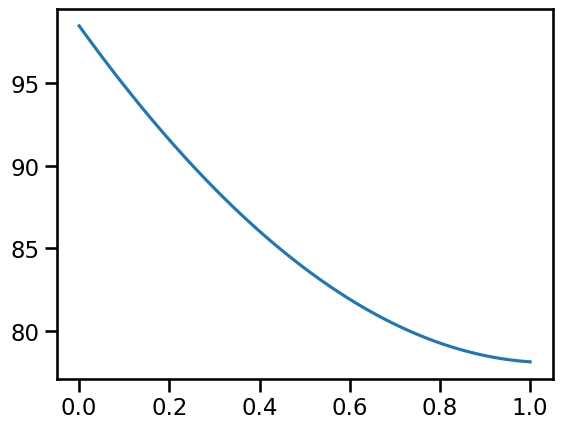

In [1326]:
Ainit = 1e-6
Atot = Ainit*sigma
alpha1 = ftot/Q1
alpha2 = ftot/Q2

A1 = brentq(A1_steady_state, 0, rtot, args=(Atot, k1, koff, k2, rtot))
A2 = A2_steady_state(A1_sol[i], k2, koff, rtot)
A1 = A1*tumour_cell_IS_proportion
A2 = A2*tumour_cell_IS_proportion
beta1 = A1/ftot
beta2 = A2/ftot
print(alpha1, alpha2, beta1, beta2)
print(beta1 + beta2)
x = np.linspace(0, np.min((1, beta1)), 100)
plt.plot(x, nondim_lig_poly(x, alpha1, alpha2, beta1, beta2))


In [1327]:
def x2_nullcline1(x1, alpha2, beta2):

    a = alpha2
    b = alpha2*(x1-1-beta2) - 1
    c = alpha2*beta2*(1-x1)

    return (-b + np.sqrt(b**2 - 4*a*c))/2*a

def x2_nullcline2(x1, alpha2, beta2):

    a = alpha2
    b = alpha2*(x1-1-beta2) - 1
    c = alpha2*beta2*(1-x1)

    return (-b - np.sqrt(b**2 - 4*a*c))/2*a

def x1_nullcline3(x2, alpha1, beta1):

    a = alpha1
    b = alpha1*(x2-1-beta1) - 1
    c = alpha1*beta1*(1-x2)

    return (-b + np.sqrt(b**2 - 4*a*c))/2*a

def x1_nullcline4(x2, alpha1, beta1):

    a = alpha1
    b = alpha1*(x2-1-beta1) - 1
    c = alpha1*beta1*(1-x2)

    return (-b - np.sqrt(b**2 - 4*a*c))/2*a

def x1_nullcine5(x1, alpha1, beta1):

    return 1 - x1 - x1/(alpha1*(beta1-x1))

def x2_nullcine6(x2, alpha2, beta2):

    return 1 - x2 - x2/(alpha2*(beta2-x2))

59245.793243625354 52192.72261938424 0.01360895555013825 0.030700997381966116


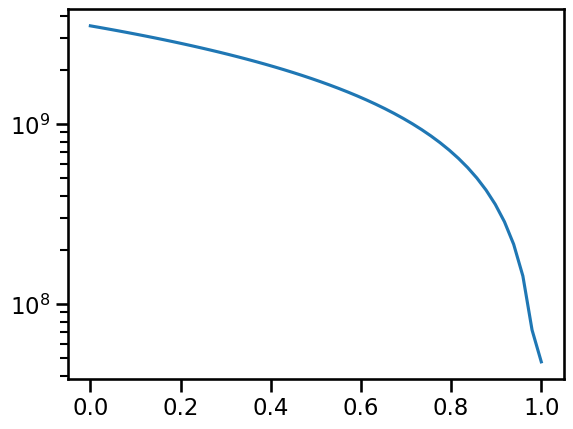

In [1328]:
ftot1 = 2.2e5
ftot = ftot1*NK_cell_IS_proportion
D_t = 1e-14
D_f = 7.4e-14
qoff = 4.7e-3
k4 = 2*(D_t +D_f)/(synapse_area)   
k5 = 2*(D_f)/(synapse_area)/1
Q1 = qoff/k4
Q2 = qoff/k5

Ainit = 1e-6
Atot = Ainit*sigma
alpha1 = ftot/Q1
alpha2 = ftot/Q2

A1 = brentq(A1_steady_state, 0, rtot, args=(Atot, k1, koff, k2, rtot))
A2 = A2_steady_state(A1, k2, koff, rtot)
A1 = A1*tumour_cell_IS_proportion
A2 = A2*tumour_cell_IS_proportion
beta1 = A1/ftot
beta2 = A2/ftot
print(alpha1, alpha2, beta1, beta2)
x2s = np.linspace(0, 1, 50)
quant = np.zeros_like(x2s)
for i, x2 in enumerate(x2s):

    a = alpha1
    b = alpha1*(x2-1-beta1) - 1
    c = alpha1*beta1*(1-x2)
    quant[i] = b**2 - 4*a*c

plt.semilogy(x2s, x1_nullcline3(x2s, alpha1, beta1))

0.7161719853307682 0.01700242765755913
5924.579324362536 0.05219272261938424 0.7161719853307682 0.01700242765755913
[0.7157466067779037] [0.00024834570112300955]


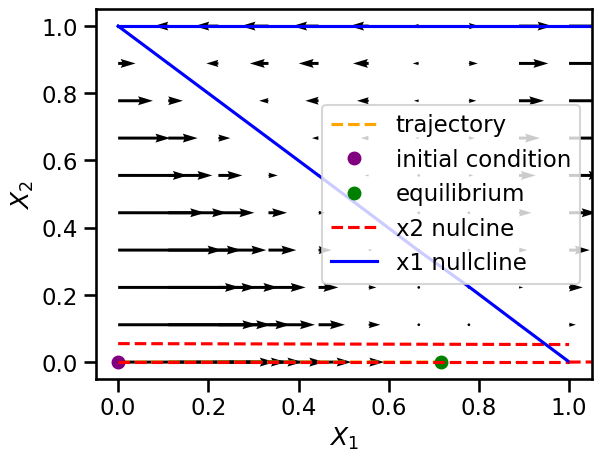

In [1329]:
ftot1 = 2.2e4
ftot = ftot1*NK_cell_IS_proportion
D_t = 1e-14
D_f = 7.4e-14
qoff = 4.7e-3
k4 = 2*(D_t +D_f)/(synapse_area)   
k5 = 2*(D_f)/(synapse_area)/100000
Q1 = qoff/k4
Q2 = qoff/k5
x1 = np.linspace(0, 1, 10)
x2 = np.linspace(0, 1, 10)

Ainit = 5e-4
Atot = Ainit*sigma
alpha1 = ftot/Q1
alpha2 = ftot/Q2

A1 = brentq(A1_steady_state, 0, rtot, args=(Atot, k1, koff, k2, rtot))
A2 = A2_steady_state(A1, k2, koff, rtot)
A1 = A1*tumour_cell_IS_proportion
A2 = A2*tumour_cell_IS_proportion
beta1 = A1/ftot
beta2 = A2/ftot
print(beta1, beta2)

Y1, Y2 = np.meshgrid(x1, x2)

A1, A2 = np.zeros(Y1.shape), np.zeros(Y2.shape)

Ni, Nj = Y1.shape

t =np.geomspace(1e-6*qoff, 10000000*qoff, 100)
tspan = [1e-6*qoff, 10000000*qoff]

for i in range(Ni):
    for j in range(Nj):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = nondim_lig_comp(t, [x, y], alpha1, alpha2, beta1, beta2)
        A1[i, j] = yprime[0]
        A2[i, j] = yprime[1]

z = solve_ivp(nondim_lig_comp, tspan, z0, method='Radau', t_eval=t, args =(alpha1, alpha2, beta1, beta2))
import seaborn as sns
print(alpha1, alpha2, beta1, beta2)
sns.set_context('talk')
z1 = z.y[0]
z2 = z.y[1]
Q = plt.quiver(Y1, Y2, A1, A2, color='black')
plt.plot(z1, z2, '--', label='trajectory', c='orange')
plt.plot([z1[0]], [z2[0]], 'o', c = 'purple',label='initial condition')
plt.plot([z1[-1]], [z2[-1]], 'o', c='green', label='equilibrium')
print([z1[-1]], [z2[-1]])
plt.plot(x1, x2_nullcline1(x1, alpha2, beta2), label='x2 nulcine', color='red', linestyle='dashed')
plt.plot(x1, x2_nullcline2(x1, alpha2, beta2), color='red', linestyle='dashed')
plt.plot(x1_nullcline3(x2, alpha1, beta1), x2, label = 'x1 nullcline', color='blue')
plt.plot(x1_nullcline4(x2, alpha1, beta1), x2,  color='blue')
plt.plot(x1, x1_nullcine5(x1, alpha1, beta1),  color='blue')
plt.plot(x2_nullcine6(x2, alpha2, beta2), x2,  color='red', linestyle='dashed')
plt.legend(loc='best')
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.ylim(-0.05,1.05)
plt.xlim(-0.05,1.05)
plt.show()

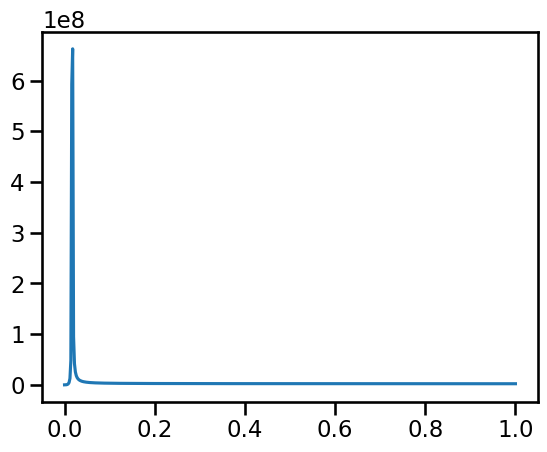

In [1330]:
def nondim_stst(x2, alpha1, alpha2, beta1, beta2):
    x1 = 1 - x2 - x2/(alpha2*(beta2-x2))

    return alpha1*(1-x1-x2)*(beta1-x1) - x1

x2s = np.linspace(0, 1, 500)

plt.plot(x2s, nondim_stst(x2s, alpha1, alpha2, beta1, beta2))


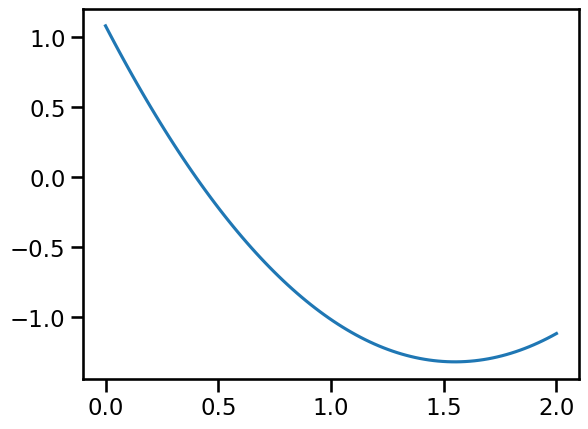

In [1339]:
def poly(x, beta1, beta2, alpha2):
    a = 1
    b = beta1-beta2-1-alpha2
    c = beta2*(1-beta1)

    return a*(x**2) + b*x + c

beta1 = 0.1
beta2 = 1.2
alpha2 = 1

x = np.linspace(0, 2, 100)
plt.plot(x, poly(x, beta1, beta2, 1/alpha2))